In [13]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer
import clean_dataset
# Turn interactive plotting off
plt.ioff()

# read input text and put data inside a data frame
clean_dataset.clean_suppervised()
data = pd.read_csv("../data/base_prospect_suppervised.csv",encoding="ISO-8859-1")
# prospect =  pd.DataFrame(prospect)
data['risque'] = data['risque'].astype(object)
# data['ca_total_FL'] = data['ca_total_FL'].astype(object)
# data['effectif'] = data['effectif'].astype(object)

y = data['rdv']

data.head
data.dtypes

code_cr             object
dept                 int64
effectif             int64
ca_total_FL          int64
ca_export_FK       float64
risque              object
endettement        float64
evo_benefice       float64
ratio_benef        float64
evo_effectif       float64
evo_risque           int64
age                  int64
type_com            object
activite            object
actionnaire         object
forme_jur_simpl     object
chgt_dir             int64
rdv                  int64
dtype: object

In [14]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown="ignore")

feature_names  = data.columns.values[2:-1]
X = data[feature_names]
#La liste des caisses régionales
lst_caisse=data['code_cr'].unique()

X_cat = X.select_dtypes(exclude=['float64','int64'])

# Disjonction with OneHotEncoder
# encoder.fit(X_cat)
# X_cat = encoder.transform(X_cat).toarray()

X_cat = pd.get_dummies(X_cat)
cat_columns = X_cat.columns
cat_columns

# X.dtypes

Index(['risque_eleve', 'risque_faible', 'risque_moyen',
       'type_com_Commune monopolarisÃ©e', 'type_com_Commune multipolarisÃ©e',
       'type_com_Espace Ã  dominante rurale', 'type_com_PÃ´le urbain',
       'activite_Commerce Autres',
       'activite_Commerce de gros et intermÃ©diaires du commerce',
       'activite_Construction : Autres',
       'activite_Construction : Travaux divers. Menuiserie. Miroiterie',
       'activite_Hotels et restaurants',
       'activite_Industrie alimentaire. bois.cuir',
       'activite_Industrie manufacturiÃ¨re : Autres',
       'activite_Industrie manufacturiÃ¨re : MÃ©tallurgie. travail des mÃ©taux',
       'activite_SantÃ© et action sociale. services sociaux. Ã©ducation. autres',
       'activite_Services. Location. Immobilier', 'activite_Transport',
       'actionnaire_entreprise', 'actionnaire_famille',
       'actionnaire_pas d'actionnaire', 'actionnaire_personne physique',
       'forme_jur_simpl_Affaire personnelle', 'forme_jur_simpl_Autre

In [15]:
from sklearn.preprocessing import StandardScaler
# Normalize data
scaler = StandardScaler()
X_num = X.select_dtypes(include=['float64','int64']).drop(columns=['chgt_dir'])
num_columns = X_num.columns
X_num_norm = scaler.fit_transform(X_num)

In [16]:
# num_cat_columns = pd.concat([X_num_norm, X_cat], axis=1).columns
X_num_cat = pd.concat([pd.DataFrame(X_num_norm), X_cat], axis=1)
num_cat_columns = num_columns.tolist()
num_cat_columns.extend(cat_columns.tolist())

In [17]:

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate

from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import DetCurveDisplay, RocCurveDisplay



from sklearn.impute import SimpleImputer
# create an instance of the RandomForestClassifier class
rdforest = RandomForestClassifier(class_weight='balanced',random_state=42,max_depth=6,min_samples_leaf=2, min_samples_split=10, n_estimators=50) #min_samples_leaf=2, min_samples_split=10, n_estimators=50
# define a grid of hyperparameters to search over
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

lst_classif = [rdforest]
lst_classif_names = ['Random Forest']
class_names = list(map(str, data['rdv'].unique()))


def accuracy_score(X,y):
    for clf,name_clf in zip(lst_classif,lst_classif_names):
        # grid_search = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1)
        # grid_search.fit(X, y)

        # # print the best hyperparameters and the corresponding validation score
        # print("Best Hyperparameters:", grid_search.best_params_)
        # print("Validation Score:", grid_search.best_score_)
        skf = StratifiedKFold(n_splits=5,shuffle=True)
        scores = cross_val_score(clf, X, y, cv=skf)
        pass


def confusion_matrix(X,y, datatype):
    for clf,name_clf in zip(lst_classif,lst_classif_names):
        predicted = cross_val_predict(clf, X, y, cv=5) 
        print("Accuracy of "+name_clf+" classifier on cross-validation: %0.2f" % metrics.accuracy_score(y, predicted))
        cm = metrics.confusion_matrix(y, predicted)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
        disp.plot()
        plt.savefig('../fig/confusion_matrix_{}'.format(datatype))
        plt.close()
    pass

In [18]:
def important_features(X,columns,type_features):
    rdforest.fit(X, y)

    importances = rdforest.feature_importances_

    forest_importances = pd.Series(importances, index=columns)
    std = np.std([tree.feature_importances_ for tree in rdforest.estimators_], axis=0)


    fig, ax = plt.subplots()
    fig.set_size_inches(6,8)
    
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
    plt.savefig('../fig/important_features_{}'.format(type_features))
    plt.show()
    plt.close()

In [19]:
from sklearn import tree
# Plot decision tree for one of the trees in the forest
def plot_decision_tree(X,y,columns,type_tree):
    rdforest.fit(X, y)
    plt.figure(figsize=(20,10))
    tree.plot_tree(rdforest.estimators_[0], feature_names=columns, class_names=class_names, filled=True,fontsize=9)
    plt.subplots_adjust(hspace=3)
    plt.savefig('../fig/decision_tree_{}'.format(type_tree))
    plt.close()

    #Large plotting for interpretation
    plt.figure(figsize=(100,10))
    tree.plot_tree(rdforest.estimators_[0], feature_names=columns, class_names=class_names, filled=True,fontsize=11)
    plt.subplots_adjust(hspace=3)
    plt.savefig('../fig/decision_tree_{}_large'.format(type_tree))
    plt.close()

In [20]:
# accuracy_score(X_num_cat.to_numpy(), y)
# accuracy_score( X_num_norm, y)
# accuracy_score( X_cat.to_numpy(), y)

In [21]:
# confusion_matrix(X_num_norm, y,"num")
# confusion_matrix(X_cat.to_numpy(), y,"cat")
# confusion_matrix(X_num_cat.to_numpy(), y, "num_cat")

In [22]:



# plot_decision_tree(X_cat, y, cat_columns , "categorical")
# plot_decision_tree(X_num_norm, y, num_columns,"numerical")
# plot_decision_tree(X_num_cat, y, num_cat_columns,"categorical_numerical")

In [23]:

# important_features(X_num_cat,num_cat_columns,"num_cat")
# important_features(X_cat,cat_columns,"cat")
# important_features(X_num_norm,num_columns,"num")

Accuracy of Random Forest classifier on cross-validation: 0.55


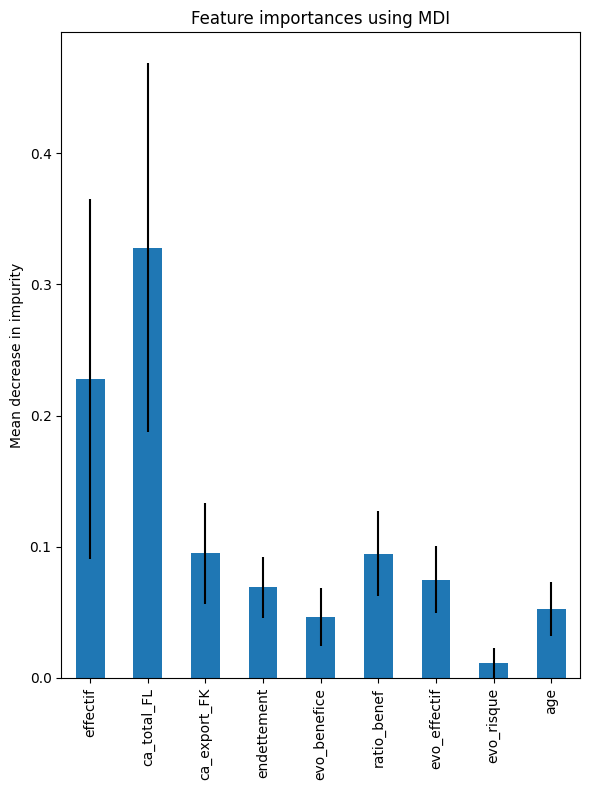

Accuracy of Random Forest classifier on cross-validation: 0.56


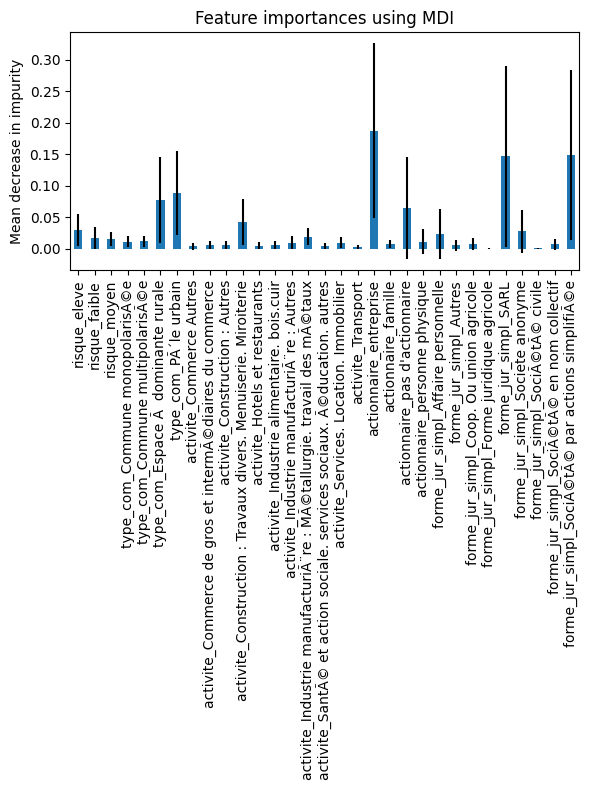

Accuracy of Random Forest classifier on cross-validation: 0.61


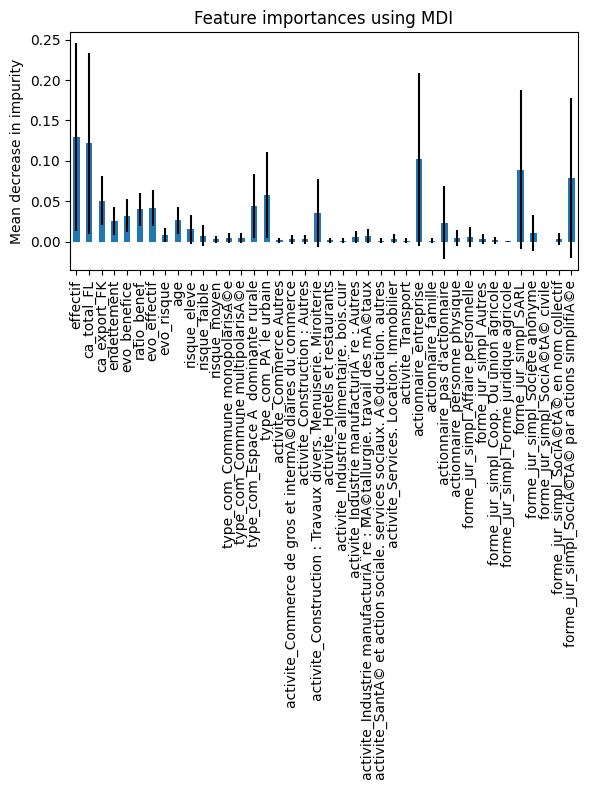

In [24]:
X_lists = [X_num_norm, X_cat.to_numpy(), X_num_cat.to_numpy()]
data_columns = [num_columns,cat_columns, num_cat_columns]
data_type_label = ["numerical","categorical", "categorical_numerical"]
zipped_data = list(zip(X_lists, data_columns, data_type_label))
for X_data, columns, label in zipped_data:
    accuracy_score(X_data, y)
    confusion_matrix(X_data, y,label)
    plot_decision_tree(X_data, y, columns , label)
    important_features(X_data,columns,label)